<a href="https://colab.research.google.com/github/jramosy/jramosy/blob/main/Copia_de_01_MissingData_FeatureEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src = "https://github.com/barcelonagse-datascience/academic_files/raw/master/images/BSE_DSC_HEADER.jpg">

$\newcommand{\bb}{\boldsymbol{\beta}}$
$\DeclareMathOperator{\Gau}{\mathcal{N}}$
$\newcommand{\bphi}{\boldsymbol \phi}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\by}{\boldsymbol{y}}$
$\newcommand{\bz}{\boldsymbol{z}}$
$\newcommand{\whbb}{\widehat{\bb}}$
$\newcommand{\hf}{\hat{f}}$
$\newcommand{\tf}{\tilde{f}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Var}{Var}$
$\newcommand{\Cov}{Cov}$
$\newcommand{\Cor}{Cor}$

# Handling Missing Data

Datasets in real life are rarely complete, so handling missing data is a common topic in data science.
The way we handle such data may have a substantial effect on our results, so caution when dealing with NAs is advisable.

After the computing bootcamp you are well familiar with the basics of `R`. Here we briefly introduce the most common ways to deal with missing data. It is important to know what happens behind the scenes before we rely on prediction methods that internally deal with missing data.

Generally speaking, it is good practice to handle missing data ourselves before considering any model.


In [6]:
## Housekeeping
rm(list = ls())
## Libraries
library(dplyr) # Dplyr is a part of the tidyverse
library(repr) # repr helps us plotting nice graphs in jupyter


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [ ]:
install.packages('dplyr')

## Sample dataset
We will use the Titanic passenger dataset as an illustration.

Data comes from the open repository https://hbiostat.org/data/repo/titanic3.csv.
Main features of 1309 passengers are:

 +   pclass: Passenger class (1 = 1st; 2 = 2nd; 3 = 3rd)
 +   survival: A Boolean indicating whether the passenger survived or not (0 = No; 1 = Yes)
 +   name: title and family names
 +   sex: male/female
 +   age: Age
 +   sibsp: Number of siblings/spouses aboard
 +   parch: Number of parents/children aboard
 +   ticket: Ticket number.
 +   fare: Passenger fare (British Pound).
 +   cabin: Location of the cabin
 +   embarked: Port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
 +   boat: Lifeboat
 +   body: Body Identification Number
 +   home.dest: Home/destination

Suppose we are interested in predicting whether the passenger survived or not. It is important to stress that, for supervised learning, we will always assume that the **labels (or target variables) do not have missing values**. We only allow for missing values in the predictor variables.

In [7]:
# Read the dataset
data <- read.csv("https://github.com/barcelonagse-datascience/academic_files/raw/master/data/titanic3.csv",
 stringsAsFactors = FALSE) #does not convert strings into factors (categorical variables)
head(data) # Print the first 5 observations
dim(data) # What are the dimensions of our data?
nrow(data) # Number of rows
ncol(data) # Number of columns

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>
1,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NA,"St Louis, MO"
2,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NA,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,,NA,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,,135,"Montreal, PQ / Chesterville, ON"
5,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,,NA,"Montreal, PQ / Chesterville, ON"
6,1,1,"Anderson, Mr. Harry",male,48.00,0,0,19952,26.5500,E12,S,3,NA,"New York, NY"


[1] 1309   14

[1] 1309

[1] 14

In [8]:
tail(data)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>
1304,3,0,"Yousseff, Mr. Gerious",male,NA,0,0,2627,14.4583,,C,,NA,
1305,3,0,"Zabour, Miss. Hileni",female,14.5,1,0,2665,14.4542,,C,,328,
1306,3,0,"Zabour, Miss. Thamine",female,NA,1,0,2665,14.4542,,C,,NA,
1307,3,0,"Zakarian, Mr. Mapriededer",male,26.5,0,0,2656,7.2250,,C,,304,
1308,3,0,"Zakarian, Mr. Ortin",male,27.0,0,0,2670,7.2250,,C,,NA,
1309,3,0,"Zimmerman, Mr. Leo",male,29.0,0,0,315082,7.8750,,S,,NA,


#### A word of caution
It is important to think carefully about missing data. Sometimes they may just be data which is randomly missing, in which case we would like to replace them with some values that preserve the structure of the data. Alternatively, the missing data may have some particular meaning. In our dataset, for instance, the feature _body_ of survivors is missing: they survived!

In [9]:
colnames(data)

[1] "pclass"    "survived"  "name"      "sex"       "age"       "sibsp"    
 [7] "parch"     "ticket"    "fare"      "cabin"     "embarked"  "boat"     
[13] "body"      "home.dest"

In [10]:
!(c('andre','joan') %in% c('mark','john','joan'))

[1]  TRUE FALSE

In [11]:
# Just for simplicity, drop some non-binary categorical variables and id vars
drop <- c("name", "body", "ticket", "embarked", "home.dest", "boat","cabin")
data <- data[, !(colnames(data) %in% drop)]
colnames(data)
head(data,10)

[1] "pclass"   "survived" "sex"      "age"      "sibsp"    "parch"    "fare"

,pclass,survived,sex,age,sibsp,parch,fare
,<int>,<int>,<chr>,<dbl>,<int>,<int>,<dbl>
1,1,1,female,29.00,0,0,211.3375
2,1,1,male,0.92,1,2,151.5500
3,1,0,female,2.00,1,2,151.5500
4,1,0,male,30.00,1,2,151.5500
5,1,0,female,25.00,1,2,151.5500
6,1,1,male,48.00,0,0,26.5500
7,1,1,female,63.00,1,0,77.9583
8,1,0,male,39.00,0,0,0.0000
9,1,1,female,53.00,2,0,51.4792


We can then compute the number (or percentage of) NA for each feature:

In [12]:
sum(is.na(data))

[1] 264

In [13]:
na_cols <- colMeans(is.na(data)) * 100 # times 100 to get percentage
na_cols

pclass    survived         sex         age       sibsp       parch 
 0.00000000  0.00000000  0.00000000 20.09167303  0.00000000  0.00000000 
       fare 
 0.07639419

And plot it, if we want.

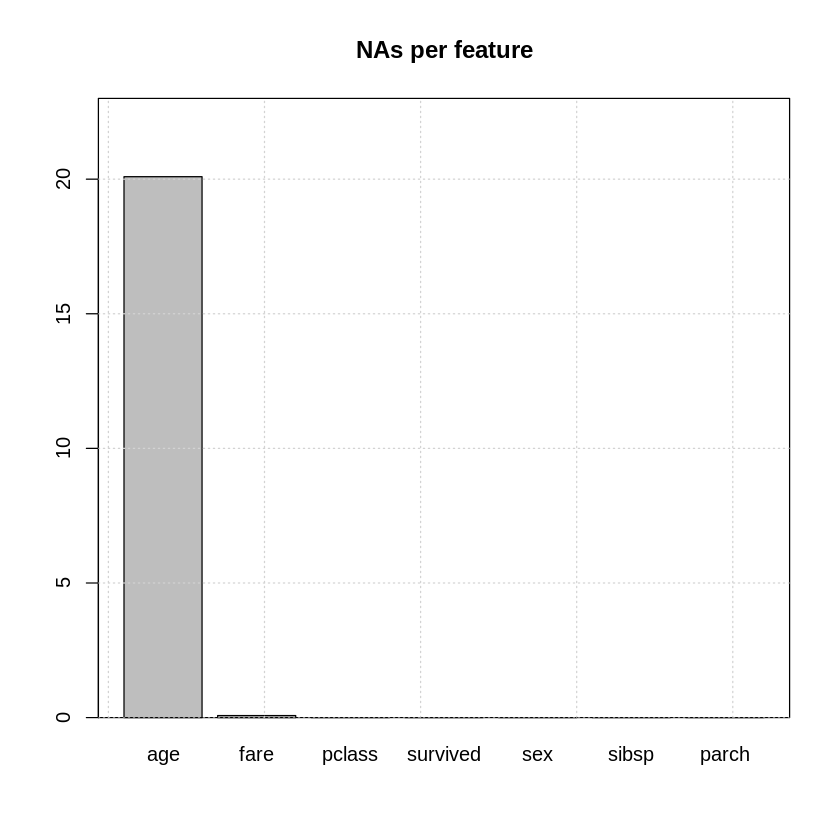

In [ ]:
barplot(sort(na_cols, decreasing = TRUE),
  ylim = c(0, 23),
  main = "NAs per feature"
)
box()
grid()

Lets get the names of features with missing observations.

In [14]:
na_cols

pclass    survived         sex         age       sibsp       parch 
 0.00000000  0.00000000  0.00000000 20.09167303  0.00000000  0.00000000 
       fare 
 0.07639419

In [15]:
na_cols[na_cols>0]

age        fare 
20.09167303  0.07639419

We see that both _age_ and _fare_  have missing values.

If our objective is to predict titanic survivors, and we believe that _age_ and _fare_ are helpful in predicting survivors, we need to deal with these missing values.

## Simple imputation methods

### Remove empty columns/rows
We could just remove the rows or columns that have a missing value. Suppose first we decide to delete columns with missing values.

In [16]:
# A drastic approach: Remove columns with any NAs
data_nona <- data[, na_cols == 0]
colnames(data_nona)

[1] "pclass"   "survived" "sex"      "sibsp"    "parch"

We can verify that we got rid of all NAs:

In [17]:
sum(is.na(data_nona))

[1] 0

And check the new dimensions of our data:

In [ ]:
dim(data_nona)

We have dealt with the NAS by removing the columns that had any NAs. But this may cost us a lot. In particular, we can no longer use the information in _age_ and _fare_ to predict _survived_. That may not be a good idea:

In [ ]:
round(cor(data$survived, data$fare, use = "pairwise.complete.obs"), 3)

[1] 0.244

The correlation between _survival_ and _fare_ is not negligible, so we may be throwing away useful information. Moreover:

In [ ]:
c(
  "Survivals" = mean(data$fare[data$survived == 1]),
  "Deaths"    = mean(data$fare[data$survived == 0], na.rm = TRUE)
)

Survivals    Deaths 
 49.36118  23.35383

The average fare for survivors seems much higher than that of deaths. This is also indicative.

In [ ]:
# also
data$children <- data$age <= 18
c(
  "Child Survivor" = mean(data$survived[data$children == 1], na.rm = TRUE)*100,
  "Adult Survivor" = mean(data$survived[data$children == 0], na.rm = TRUE)*100
)


Survivals    Deaths 
 49.22280  38.92145

In addition to that, children also were more likely to survive than adults, so we also would like to keep _age_ as a predictor

An alternative to completely removing columns with some missing data is to remove rows with missing data.

Clearly, this may cost us observations, so a better strategy is to *mix* both column and row deletion:

1. Remove columns (features) with high percentage of missing data;
2. Then, for the remaining dataset, remove rows with missing data


In [ ]:
data_nona <- data[, na_cols < 20] # First remove features
dim(data_nona)

In [ ]:
data_nona <- data_nona[rowSums(is.na(data_nona)) == 0, ] # Then, remove rows
sum(is.na(data_nona))

Now we have a bit less observations, but we kept information on age and fare. There are of course other possibilities that are useful in different settings.


### Replace by statistics (mean/median/mode)

One strategy that is typically used is to replace missing data by unconditional statistics obtained over the whole sample:
- *Mean* for numerical features where ouliers are not significant;
- *Median* for numerical features where outliers clearly affect the mean;
- *Mode* for categorical features;


In [ ]:
mean(data$age, na.rm=TRUE)

[1] 29.88114

In [ ]:
data$age_filled <- data$age
data$age_filled[is.na(data$age_filled)]  <- mean(data$age, na.rm=TRUE)

In [ ]:
any(is.na(data$age))
any(is.na(data$age_filled))

[1] TRUE

[1] FALSE

This imputation strategy is interesting as it preserves the unconditional mean of the series.
This simple imputation shrinks overall values towards the unconditional mean or median, reducing variability. We can think of different ways to avoid this, such as replacing by *conditional* statistics, i.e using particular subgroups of data and categorical variables.

Suppose we want to fill missing _age_ values with the age of a given group based on sex:

In [ ]:
data$age_sex_filled  <- data$age
missing_male   <- is.na(data$age) & data$sex=='male'
missing_female <- is.na(data$age) & data$sex=='female'
mean(data$age[data$sex=='male'],na.rm=TRUE)
mean(data$age[data$sex=='female'],na.rm=TRUE)

[1] 30.58523

[1] 28.68709

In [ ]:
data$age_sex_filled[missing_male]    <- mean(data$age[data$sex=='male'],na.rm=TRUE)
data$age_sex_filled[missing_female]  <- mean(data$age[data$sex=='female'],na.rm=TRUE)

In [ ]:
tail(data)

,pclass,survived,sex,age,sibsp,parch,fare,children,age_filled,age_sex_filled
,<int>,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<lgl>,<dbl>,<dbl>
1304,3,0,male,NA,0,0,14.4583,NA,29.88114,30.58523
1305,3,0,female,14.5,1,0,14.4542,TRUE,14.50000,14.50000
1306,3,0,female,NA,1,0,14.4542,NA,29.88114,28.68709
1307,3,0,male,26.5,0,0,7.2250,FALSE,26.50000,26.50000
1308,3,0,male,27.0,0,0,7.2250,FALSE,27.00000,27.00000
1309,3,0,male,29.0,0,0,7.8750,FALSE,29.00000,29.00000


`dplyr' is a widely used package in R. A potential solution using dplyr would be:

In [ ]:
data_nona <- data %>%
  group_by(sex) %>% # First, take the data and group by gender.
  mutate(age_filled = ifelse(is.na(age), # Then, if age is NA, age_filled is the average age within a group)
    mean(age,
      na.rm = TRUE
    ), age
  ))
data_nona[is.na(data$age), c("age", "age_filled", "sex")]

age,age_filled,sex
<dbl>,<dbl>,<chr>
NA,30.58523,male
NA,30.58523,male
NA,30.58523,male
NA,30.58523,male
NA,28.68709,female
NA,28.68709,female
NA,30.58523,male
NA,30.58523,male
NA,30.58523,male


### Propagate previous/next value
This method basically consists of filling a gap with previous or posterior observations of the same feature.

This approach would typically make sense when there is a natural ordering in data (e.g. time series), **but we have to be careful!** if the goal is prediction, it may not be a great idea to use future values to replace past values.

For an example of when this could be sensible, if we have a sequence of daily stock prices where one day is a holiday, we may just want to fill this using the last available price.

In [ ]:
my_data

y,x
<int>,<dbl>
1,1
2,NA
3,3
4,4
5,5
6,6
7,NA
8,NA
9,NA


In [ ]:
# Lets see how forward filling works
my_data <- cbind.data.frame("y" = 1:10, "x" = c(1, NA, 3, 4, 5, 6, NA, NA, NA, 10))
tidyr::fill(my_data, .direction = "down", "x")

y,x
<int>,<dbl>
1,1
2,1
3,3
4,4
5,5
6,6
7,6
8,6
9,6


In [ ]:
# and backwards
tidyr::fill(my_data, .direction = "downup", "x")

y,x
<int>,<dbl>
1,1
2,3
3,3
4,4
5,5
6,6
7,10
8,10
9,10


### Using models to impute data
We can also use formal statistical models to impute data.
In particular, we can just treat the missing data as a prediction problem, and predict the missing values using any of the models we will see in the upcoming lectures. There are also other more complex ways of dealing with this, but we will not go in more detail for now.

# Feature Engineering


## Summary

Input variables are not necessarily the features that one finally uses to build prediction models. The process that transforms input variables into features is what we call *feature engineering*.

Some prediction models, like neural networks, have already embedded some feature engineering, but for most of them, transforming input variables in a proper way may make the difference in terms of final performance.

This is just a high level introduction of techniques for feature engineering, with some links for further reading.

# Feature transformation

## Binning
This is the process of aggregating a continuous variable into bins. For example, from *grades* to *grade_class* (A, B, C), or from age into age groups, as we did above. This is widely used in finance for creating portfolios based on quantiles of some variables. For example, we may want to split fares into 10 bins created from quantiles.

In [ ]:
cor(data$age,data$survived,use='pairwise.complete.obs')

[1] -0.05551184

In [ ]:
quantile(data$fare,na.rm=TRUE)

0%      25%      50%      75%     100% 
  0.0000   7.8958  14.4542  31.2750 512.3292

In [ ]:
data$fare_quantile <- findInterval(x = data$fare , quantile(data$fare,na.rm=TRUE))

cbind.data.frame(data$fare_quantile, data$fare)

data$fare_quantile,data$fare
<int>,<dbl>
4,211.3375
4,151.5500
4,151.5500
4,151.5500
4,151.5500
3,26.5500
4,77.9583
1,0.0000
4,51.4792


## Log transform
You may want to consider log transformations of your variables (this is very standard in economics and finance). Takings logs may decrease the effect of outliers on our models and provide a natural interpretation of coefficients in percentage terms.

Note that the log should be used with caution for negative or zero valued random variables (one may use log (abs(x+1)) plus a dummy for negative values, but in general this is a red flag)

### Example
Toy example with titanic dataset.

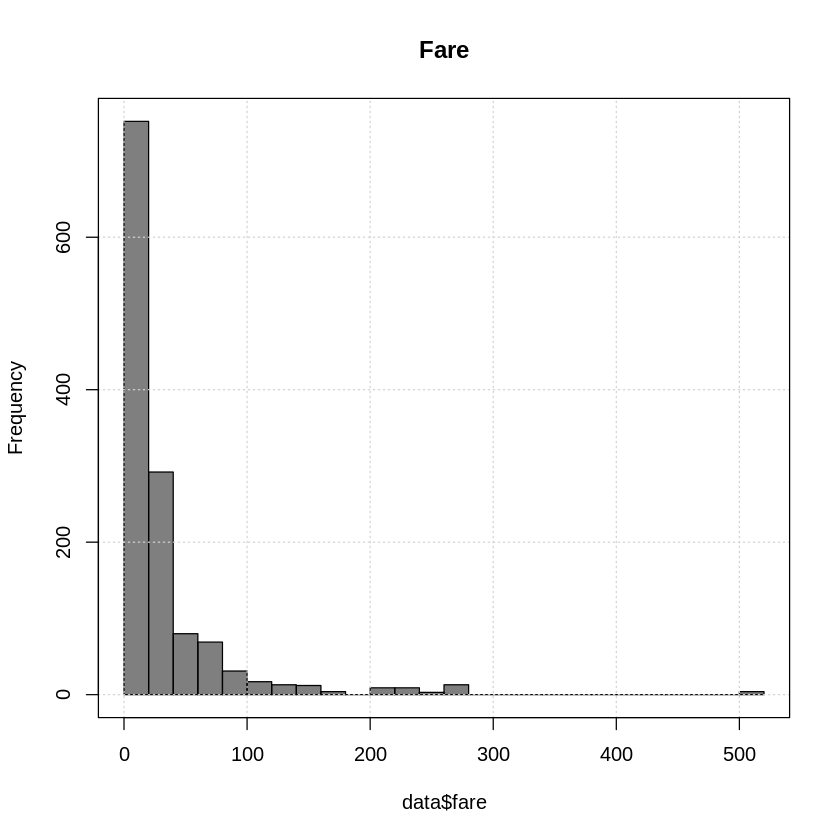

In [ ]:
# We can look at the distribution of fares with a histogram
hist(data$fare,col=rgb(0,0,0,1/2),main='Fare',breaks=20)
grid()
box()

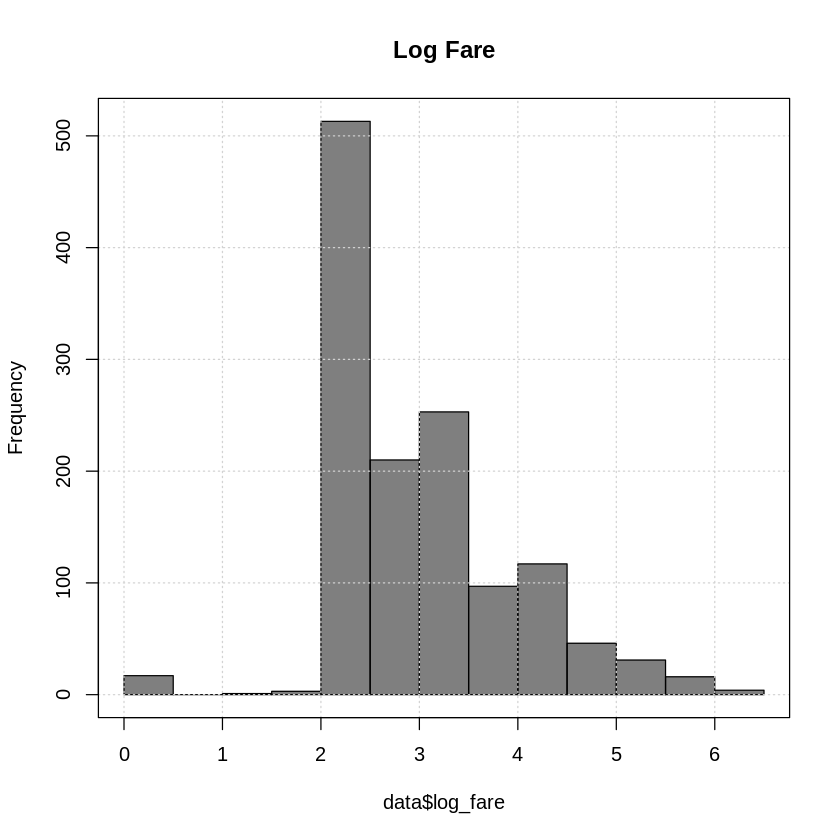

In [ ]:
# and construct the log of the fare
data$log_fare = log(data$fare + 1) # to deal with the 0 values
# Plot
hist(data$log_fare, col=rgb(0,0,0,1/2),main='Log Fare',breaks=20)
grid()
box()


## Scaling (Normalization/Standardization)

We typically want variables to have, loosely speaking, a sensible scale.
A few usual options are:

+ Standardization: Removes the mean and scales to unit variance. This is the standard definition of scaling. After the transformation, all variables have the same mean (0) and variance (1).

+ Robust: Similar to the standard but more robust to outliers. Removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). Note that now the output won't have a mean of 0 and a standard deviation of 1

+ MinMax: Linear scaling to an output range, just considering the minimum and maximum. Just note that default range is (0,1). The output is not necessarily _well behaved_  and this is very sensible to outliers.

In [ ]:
data$fare_SS <- (data$fare - mean(data$fare,na.rm=TRUE) )/sd(data$fare,na.rm=TRUE)
data$fare_RS <- (data$fare - median(data$fare,na.rm=TRUE) )/IQR(data$fare,na.rm=TRUE)
data$fare_MM <- (data$fare - min(data$fare, na.rm = TRUE)) / (max(data$fare, na.rm = TRUE) - min(data$fare, na.rm = TRUE))

In [ ]:
round( colMeans(data[,which(colnames(data) %in% c('fare_SS','fare_RS','fare_MM'))],na.rm=TRUE),3)

fare_SS fare_RS fare_MM 
  0.000   0.806   0.065

In [ ]:
round( apply(data[,which(colnames(data) %in% c('fare_SS','fare_RS','fare_MM'))],
             FUN = function(x) sd(x,na.rm=TRUE),
             MARGIN = 2),3)

fare_SS fare_RS fare_MM 
  1.000   2.214   0.101

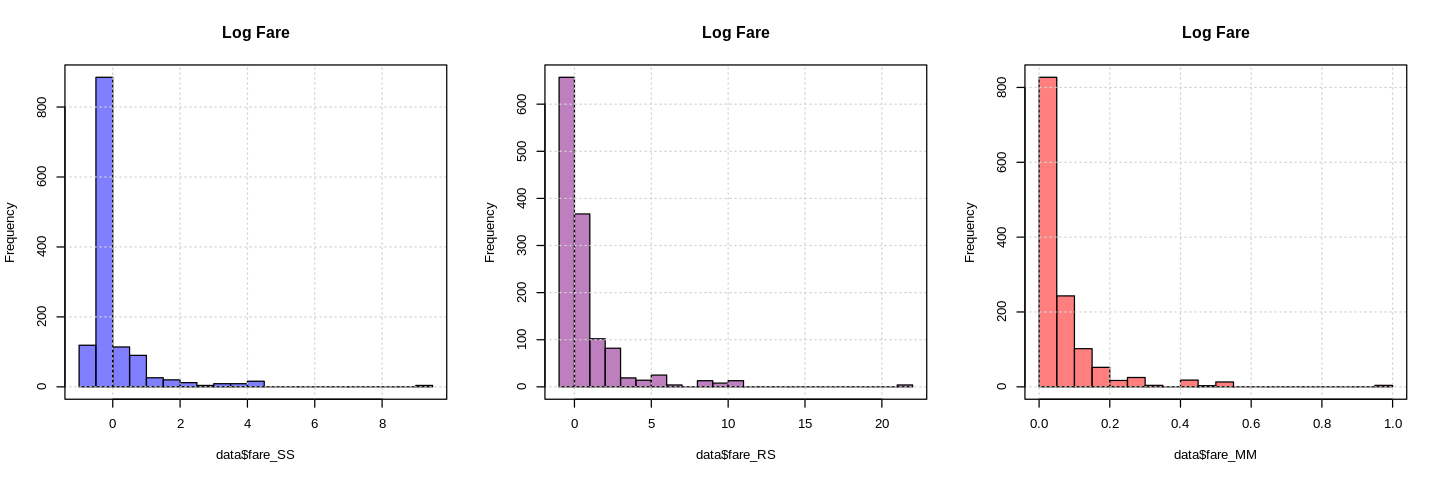

In [ ]:
options(repr.plot.width=12, repr.plot.height=4)

par(mfrow=c(1,3))
hist(data$fare_SS,col=rgb(0,0,1,1/2),main='Log Fare',breaks=20)
grid()
box()
hist(data$fare_RS,col=rgb(1/2,0,1/2,1/2),main='Log Fare',breaks=20)
grid()
box()
hist(data$fare_MM,col=rgb(1,0,0,1/2),main='Log Fare',breaks=20)
grid()
box()


## Feature Split

Especially valid for categorical data. After data exploration, you may observe that there is some structure in your data that you may want to exploit. One way to do so would be to split the data using some heuristics.

For example, for the titanic dataset, the *cabin* column has values such as B22, C12, A4, which indicates that it's probably worth to split into two (e.g. B+22, C+12, A+4) for a better representation of a spatial distribution of cabins. With hotel rooms, it may be similar (e.g. room 112 into 1(floor)+12(room number)).

In [ ]:
data <- read.csv("https://github.com/barcelonagse-datascience/academic_files/raw/master/data/titanic3.csv", stringsAsFactors = FALSE)

In [ ]:
head(data$cabin)

In [ ]:
# Cabin has a few NAS, for simplicity of exposition, lets replace them with a clear NA string
data$cabin[data$cabin==""]  <- "000000"

In [ ]:
strsplit(data$cabin[2]," ")

In [ ]:
# Split cabin in two
data$cabin_first <- sapply(1:nrow(data), function(w) strsplit(data$cabin[w]," ")[[1]][1])
data$cabin_first

## Date-time category extraction
From a date input, it might be useful to extract features like *day of week*, *month*, *year*, etc.. These could be important if there is some seasonality related to those units of measure.  For example, dummies like *Holiday_period* or *Working_day* might be important.
We will use the `lubridate` package to help us with that in the upcoming lectures.

## Combine Sparse Classes
When dealing with categories, you might test the frequency of certain classes, and group the less frequent classes, but making sure that their behavior is similar with respect to the target to predict.


# Outlier detection

Training our model on data that has *strange* observations may be misleading.

That's why it might be important to remove or treat those observations from our training dataset. Also identifying those in the test set for prediction is important, because one should expect bad performance of our model on those.

## Caution:
Outliers should not *always* be thrown out. For instance, for economic time series, should we "trim" out the covid-19 crisis episode?

# Feature generation



## Create interaction features
Linearity is a convenient modeling assumption, but it may be restrictive. It then becomes useful to consider interaction between features (or feature transformations) to capture relevant nonlinearities. We will see more about this in a bit.

### Numerical features

We may, for instance, consider polynomials of some inputs by raising them to a certain power. We may also consider cross-products of inputs (e.g. convert units sold to revenue by multiplying by prices), sums (e.g. if they are two subcategories), differences (e.g. difference in date) or ratios (e.g. students per professor) between two input features.

If you don't scale your data, you can also create *ratios* or *differences* of features versus an average value.

Alternatively, we may prefer methods that explicitly incorporates nonlinearties, such as *decision trees* or *neural networks*.

## Adding domain knowledge
This simple step basically consists of adding as features any relevant information that you may have about your data. Generally speaking, one can easily include some information as a dummy or category.

Easiest example is adding 'events' to a time series, such as sovereign debt crisis, housing debt crisis etc. This helps the model to treat a subset of data in a different way.

## Adding External data
Not having a good understanding of the context of your prediction problem may lead you to miss some relevant factors that affect your outcome. This is a hint for you to complement your input data with external information that might be relevant.

You may probably scrape data on internet to find this external data.

Here some examples:
+ Context Economic indicators (GDP, average salary, etc.), political indicators, social indicators, etc.
+ Time series evolution/pattern of similar entities.
+ Geographical info: From city, region info, obtain average position (UTM coordinates, latitude, longitude), so that you can identify neighbor observations (even add average features of close observations). The inverse also holds: from latitude/longitude or coordinates, compute not only features of neighbor observations, but also categories such as country, city, region, etc.

### Missing indicator: Don't lose information

Add boolean columns to keep track of data that was originally missing.

`
dataframe$is_na_Column_Name = is.na(dataframe$Column_Name)
`
This preserves the information, and may be relevant particularly if the NA values are not randomly distributed.


### Time series imputation
Filling gaps in time series is a particular case of handling missing data.
Time series vary by nature, but there are a few common patterns.

Often, there are missing values in the _beginning_ of the dataframe. A general solution here is to start analysis at a later date, when this is possible.

Alternatively, there may be missing values in the _end_ of the dataframe due to some series being updated faster than others. A general solution here is to cut-off the last, say, couple of observations.

More problematic cases happen when we have missing data in the _middle_ of the dataframe. If the missing data is randomly missing, a suggestion is to simply use the mean of the column. **However**, if the missing data is due to a particular event (say a stock market's circuit breakers), then the mean may be an overly optimistic value for the missing value, and care must be taken.

In addition, interpolation may be used for time series as well.

## References

Casari, A., Zheng, A., 2018. *Feature Engineering for Machine Learning*. O'Reilly Media.

Kuhn, M., Johnson, K. . 2019. [*Feature Engineering and Selection: A Practical Approach for Predictive Models*](http://www.feat.engineering/)

